<a href="https://colab.research.google.com/github/sskyau/rl-super-mario/blob/main/rl_super_mario_bros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [280]:
#!pip install nes-py==0.2.6
!pip install nes-py
!pip install gym-super-mario-bros
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

In [281]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from gym import wrappers
from gym.wrappers.frame_stack import FrameStack
from gym.wrappers.gray_scale_observation import GrayScaleObservation
from gym.wrappers.resize_observation import ResizeObservation
from gym.wrappers import AtariPreprocessing

In [282]:
# class MaxAndSkipEnv(gym.Wrapper):
#     def __init__(self, env=None, skip=4):
#         """Return only every `skip`-th frame"""
#         super(MaxAndSkipEnv, self).__init__(env)
#         # most recent raw observations (for max pooling across time steps)
#         self._obs_buffer = collections.deque(maxlen=2)
#         self._skip = skip

#     def step(self, action):
#         total_reward = 0.0
#         done = None
#         for _ in range(self._skip):
#             obs, reward, done, info = self.env.step(action)
#             self._obs_buffer.append(obs)
#             total_reward += reward
#             if done:
#                 break
#         max_frame = np.max(np.stack(self._obs_buffer), axis=0)
#         return max_frame, total_reward, done, info

#     def reset(self):
#         """Clear past frame buffer and init to first obs"""
#         self._obs_buffer.clear()
#         obs = self.env.reset()
#         self._obs_buffer.append(obs)
#         return obs


# class ProcessFrame84(gym.ObservationWrapper):
#     """
#     Downsamples image to 84x84
#     Greyscales image

#     Returns numpy array
#     """
#     def __init__(self, env=None):
#         super(ProcessFrame84, self).__init__(env)
#         self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

#     def observation(self, obs):
#         return ProcessFrame84.process(obs)

#     def process(frame):
#         if frame.size == 240 * 256 * 3:
#             img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
#         else:
#             assert False, "Unknown resolution."
#         img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
#         resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
#         x_t = resized_screen[18:102, :]
#         x_t = np.reshape(x_t, [84, 84, 1])
#         return x_t.astype(np.uint8)


# class ImageToPyTorch(gym.ObservationWrapper):
#     def __init__(self, env):
#         super(ImageToPyTorch, self).__init__(env)
#         old_shape = self.observation_space.shape
#         self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
#                                                 dtype=np.float32)

#     def observation(self, observation):
#         return np.moveaxis(observation, 2, 0)


# class ScaledFloatFrame(gym.ObservationWrapper):
#     """Normalize pixel values in frame --> 0 to 1"""
#     def observation(self, obs):
#         return np.array(obs).astype(np.float32) / 255.0


# class BufferWrapper(gym.ObservationWrapper):
#     def __init__(self, env, n_steps, dtype=np.float32):
#         super(BufferWrapper, self).__init__(env)
#         self.dtype = dtype
#         old_space = env.observation_space
#         self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
#                                                 old_space.high.repeat(n_steps, axis=0), dtype=dtype)

#     def reset(self):
#         self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
#         return self.observation(self.env.reset())

#     def observation(self, observation):
#         self.buffer[:-1] = self.buffer[1:]
#         self.buffer[-1] = observation
#         return self.buffer


# def make_env(env, frame_stack):
#     env = MaxAndSkipEnv(env)
#     env = ProcessFrame84(env)
#     env = ImageToPyTorch(env)
#     env = BufferWrapper(env, 4)
#     env = ScaledFloatFrame(env)
#     return JoypadSpace(env, SIMPLE_MOVEMENT)

In [283]:
# Custom class to make end of life = end of episode
class SkipFrame(gym.Wrapper):

  def __init__(self, env, n):
    super(SkipFrame, self).__init__(env)
    self._n = n
  
  def step(self, action):
    sum_rewards = 0
    
    # Re-run every step in the n-frames and accumulate the info to return
    done = False
    for i in range(self._n):
      #print('before step: ', done)
      state, reward, done, info = self.env.step(action)
      #print('after step: ', done)
      sum_rewards += reward
      if done:
        break
  
    return state, sum_rewards, done, info

class CustomReward(gym.Wrapper):
  def __init__(self, env):
    super(CustomReward, self).__init__(env)
    self.score = 0

  def step(self, action):
    state, reward, done, info = self.env.step(action)
    # original reward function: (new_x_pos - old_x_pos) + (new_time - old_time) + dealth_pealty(-15 if dead; 0 otherwise)
    # clipped at (-15,15)

    # Amplify rewards (10x)
    if reward > 0:
      reward *= 10
    else:
      reward -= 1
      reward *= 10
    
    # info: {'coins': (int), 
    #        'flag_get': (bool), 
    #        'life': (int), 
    #        'stage': (int), 
    #        'status': (str) {'small', 'tall', 'firecall'}, 
    #        'time': (int) time left, 
    #        'world': (int) {1,...,8}, 
    #        'x_pos': (int), 
    #        'y_pos': (int)}

           
    if info['flag_get']:
      reward += 500
    
    if info['status'] == 'tall':
      reward += 100
    
    return state, reward, done, info

class ScaleReshapeEnv(gym.ObservationWrapper):
    def __init__(self, env):
        super(ScaleReshapeEnv, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, 
                                                high=255.0, 
                                                shape=(old_shape[1], old_shape[2], old_shape[0]),
                                                dtype=np.float32)

    def observation(self, observation):
        observation = np.array(observation).astype(np.float32) / 255.0
        # print('before conversion ', observation.shape)
        shape = self.observation_space.shape
        observation = np.reshape(observation, (shape))
        return observation


def make_env(env, frame_size, frame_skip, frame_stack):
  env = JoypadSpace(env, SIMPLE_MOVEMENT)
  # print('original: ', env.observation_space.shape)
  env = CustomReward(env)
  env = SkipFrame(env, frame_skip)
  # print('after skip frame: ', env.observation_space.shape)
  env = GrayScaleObservation(env)
  # print('after grayscale: ', env.observation_space.shape)
  env = ResizeObservation(env, frame_size)
  # print('after resize: ', env.observation_space.shape)
  env = FrameStack(env, frame_stack)
  # print('after frame stack: ', env.observation_space.shape)
  env = ScaleReshapeEnv(env)
  # print('after scale reshape: ', env.observation_space.shape)
  return env

In [332]:
class UniformExperienceReplay(object):
  def __init__(self, replay_size, mem_size):
    self.sample_size = replay_size
    self.mem_size = mem_size
    self.buffer = [None] * self.mem_size
    self.index = 0
  
  def push(self, s, a, r, d, s2):
    self.buffer[self.index] = s, a, r, d, s2
    self.index += 1

    # reset if memory is full
    if self.index == self.mem_size:
      self.index = 0
      self.buffer = [None] * self.mem_size
  
  def sample_exp(self):
    s = [None] * self.sample_size
    a = [None] * self.sample_size
    r = [None] * self.sample_size
    d = [None] * self.sample_size
    s2 = [None] * self.sample_size

    for batch, sample in enumerate(np.random.randint(0, self.index-1, self.sample_size)):
      s_sample, a_sample, r_sample, d_sample, s2_sample = self.buffer[sample]
      s[batch] = np.array(s_sample)
      a[batch] = a_sample
      r[batch] = r_sample
      d[batch] = d_sample
      s2[batch] = np.array(s2_sample)
    
    return np.array(s), np.array(a, dtype=int), np.array(r, dtype=float), np.array(d, dtype=bool), np.array(s2)


In [393]:
from os import X_OK
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Lambda, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import backend as K

class DDQNMario:

    def __init__(self, state_space, action_space, mem_size, frame_stack, replay_size, gamma, lr, max_epsilon, min_epsilon, epsilon_decay, sync_rate, pretrained, burnin):
      
      self.pretrained = pretrained 

      # Learning variables
      self.gamma = gamma
      self.epsilon_decay = epsilon_decay
      self.min_epsilon = min_epsilon
      self.epsilon = max_epsilon
      self.huber = keras.losses.Huber()
      self.burnin = burnin

      # Env variables
      self.step = 0
      self.state_space = state_space
      self.num_actions = action_space
      self.frame_stack = frame_stack

      # Experience replay variables
      self.mem_size = mem_size
      self.sync_rate = sync_rate
      self.buffer = 0
      self.replay_size = replay_size
      self.replayer = UniformExperienceReplay(replay_size, self.mem_size)
      self.action_mask = np.ones(self.num_actions, dtype=int)


      # CNN network variables
      self.lr = lr
      self.optimiser = Adam(learning_rate=self.lr, clipnorm=1.0)
      self.online_hist = []

      # Init CNN networks
      if self.pretrained:
        # (Testing) use pre-trained weights for the models
        self.online = load_model('online')
        self.target = load_model('target')

      else:
        # (Training) inti models
        self.online = self.create_model()
        self.target = self.create_model()

      # Logging
      self.last_position = 0
      self.epi_exploitation = 0

    def create_model(self):
      inputs = Input(shape=(self.state_space))
      x = Conv2D(32, 3, strides=4, activation='relu', name='conv1')(inputs)
      x = Conv2D(64, 3, strides=2,  activation='relu', name='conv2')(x)
      x = Conv2D(64, 3, strides=1, activation='relu', name='conv3')(x)
      x = Flatten()(x)
      x = Dense(1024, activation='relu')(x)
      action = Dense(self.num_actions, activation='tanh', name='action')(x) 

      model = tf.keras.Model(inputs=inputs, outputs=action)

      model.compile(optimizer=self.optimiser, loss=self.huber)
      #model.summary()
      return model

    def choose_action(self, state):
      self.step += 1

      # Epsilon-greedy policy #
      # Exploration 
      if random.random() < self.epsilon:  
        return random.randrange(self.num_actions)
      
      # Exploitation
      else:
        state = state[np.newaxis, :, :, :] # (84,84,4) --> (1,84,84,4)
        actions = self.online.predict(state)
        # print(np.argmax(actions))
        self.epi_exploitation += 1

        return np.argmax(actions[0])

    def sync_models(self):
      self.target.set_weights(self.online.get_weights())

    def experience_replay(self, ep_num):
      # reference: https://colab.research.google.com/github/ehennis/ReinforcementLearning/blob/master/06-DDQN.ipynb#scrollTo=4oVZuEP5vVTP
      if self.step % self.sync_rate == 0:
        self.sync_models()

      if self.replayer.index < self.replayer.sample_size:
        return 

      s = []
      y = [] 

      # sample minibatch of state, action, reward, done and state2 
      state_sample, action_sample, reward_sample, done_sample, state2_sample = self.replayer.sample_exp()

      # predict in batch
      state_pred_online = self.online.predict(state_sample) 
      state2_pred_online = self.online.predict(state2_sample)
      state2_pred_target = self.target.predict(state2_sample)

      for i in range(len(action_sample)):
        s.append(state_sample[i])
        
        state2_action_pred_online = state2_pred_online[i]
        state2_action_pred_target = state2_pred_target[i]
      
        if done_sample[i]:
          target = reward_sample[i] # y_j = r_j + 0 if terminal
        else:
          target = reward_sample[i] + self.gamma * state2_action_pred_target[np.argmax(state2_action_pred_online)] 
        
        # y_j
        target_f = state_pred_online[i] # prediction result (array of size 7)
        target_f[action_sample[i]] = target # 
        y.append(target_f)

      s = np.array(s)
      y = np.array(y)
      
      # perform single gradient update based on y_j
      self.online_hist = self.online.train_on_batch(s, y)

      # Update epsilon (only after burnin, let agent explore more before exploitation)
      if ep_num >= self.burnin:
        self.epsilon = max(self.min_epsilon, self.epsilon*self.epsilon_decay)

    def log(self, state, action, reward, done, state2):
      # print('shape of state logged: ', state.shape)
      self.replayer.push(state, action, reward, done, state2)

In [383]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [394]:
frame_stack = 4
def run(training_mode, pretrained, stage):
   


    env = gym_super_mario_bros.make(stage) # world 1, stage 1, standard ROM
    env = make_env(env, 
                   frame_size=84,
                   frame_skip=4,
                   frame_stack=frame_stack)  # Wraps the environment so that frames are grayscale 
    state_space = env.observation_space.shape
    # print('observation space: ', env.observation_space.shape)
    action_space = env.action_space.n

    # Init
    num_episodes = 200
    burnin = int(num_episodes * 0.05)
    env.reset()
    total_rewards = []
    exploitation_rate = []

    agent = DDQNMario(state_space=(84,84,4),
                      action_space=action_space,
                      frame_stack=frame_stack,
                      mem_size=10000,
                      replay_size=32,
                      gamma=0.90,
                      lr=.00025,
                      max_epsilon=1.0,
                      min_epsilon=0.1,
                      epsilon_decay=0.9999,
                      sync_rate = 10000, 
                      burnin = burnin,
                      pretrained=pretrained)
    
    
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        # print(state)
        state = state
        total_reward = 0
        steps = 0
        agent.epi_exploitation = 0

        while True:

            if not training_mode: 
                show_state(env, ep_num)
            # print('choose action')
            action = agent.choose_action(state)
            # print('state shape fed into choose action',state.shape)
            steps += 1
            
            state2, reward, done, info = env.step(int(action))
            # print(state2)
            # print('env shape', env.observation_space.shape)
            # print('shape of state returned in step:', state2.shape)
            total_reward += reward
            state2 = state2
            
            if training_mode:
                agent.log(state, action, reward, done, state2)
                agent.experience_replay(ep_num
                                        )
            
            state = state2
            if done:
                exploitation_rate.append(agent.epi_exploitation / steps)
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}. Exploitation rate is {}%.".format(ep_num + 1, total_rewards[-1], exploitation_rate[ep_num]*100))
        num_episodes += 1      
    
    if training_mode:
        # save training record 
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.last_position, f, protocol=4)
        with open("buffer.pkl", "wb") as f:
            pickle.dump(agent.replayer.buffer, f, protocol=4)
        
        agent.online.save("online")
        agent.target.save("target")

    env.close()
    
    if num_episodes > burnin:
        plt.title("Episodes trained vs. Average Rewards")
        plt.plot([0 for _ in range(burnin)] + 
            np.convolve(total_rewards, np.ones((burnin,))/burnin, mode="valid").tolist())
        plt.show()

In [ ]:
run(training_mode=True, pretrained=False, stage='SuperMarioBros-1-4-v0')

  0%|          | 1/200 [00:01<04:43,  1.43s/it]

Total reward after episode 1 is 1370. Exploitation rate is 0.0%.


  1%|          | 2/200 [00:20<38:08, 11.56s/it]

Total reward after episode 2 is 3020. Exploitation rate is 0.0%.


  2%|▏         | 3/200 [00:42<54:35, 16.63s/it]

Total reward after episode 3 is 2040. Exploitation rate is 0.0%.


  2%|▏         | 4/200 [00:57<51:37, 15.80s/it]

Total reward after episode 4 is 3360. Exploitation rate is 0.0%.


  2%|▎         | 5/200 [01:19<59:17, 18.24s/it]

Total reward after episode 5 is 2570. Exploitation rate is 0.0%.


  3%|▎         | 6/200 [01:35<55:56, 17.30s/it]

Total reward after episode 6 is 3290. Exploitation rate is 0.0%.


  4%|▎         | 7/200 [01:45<48:11, 14.98s/it]

Total reward after episode 7 is 1220. Exploitation rate is 0.0%.


  4%|▍         | 8/200 [01:54<41:58, 13.12s/it]

Total reward after episode 8 is 1160. Exploitation rate is 0.0%.


  4%|▍         | 9/200 [02:08<42:37, 13.39s/it]

Total reward after episode 9 is 3330. Exploitation rate is 0.0%.


  5%|▌         | 10/200 [02:30<51:00, 16.11s/it]

Total reward after episode 10 is 2080. Exploitation rate is 0.0%.


  6%|▌         | 11/200 [02:56<59:51, 19.00s/it]

Total reward after episode 11 is 2200. Exploitation rate is 0.0%.


  6%|▌         | 12/200 [03:07<51:42, 16.50s/it]

Total reward after episode 12 is 970. Exploitation rate is 0.0%.


  6%|▋         | 13/200 [03:27<55:03, 17.66s/it]

Total reward after episode 13 is 2610. Exploitation rate is 1.1764705882352942%.


  7%|▋         | 14/200 [03:43<52:48, 17.03s/it]

Total reward after episode 14 is 3830. Exploitation rate is 1.4492753623188406%.


  8%|▊         | 15/200 [03:58<50:54, 16.51s/it]

Total reward after episode 15 is 3780. Exploitation rate is 5.970149253731343%.


  8%|▊         | 16/200 [04:17<52:50, 17.23s/it]

Total reward after episode 16 is 2570. Exploitation rate is 3.5294117647058822%.


  8%|▊         | 17/200 [04:33<51:29, 16.88s/it]

Total reward after episode 17 is 3070. Exploitation rate is 2.857142857142857%.


  9%|▉         | 18/200 [04:48<49:16, 16.24s/it]

Total reward after episode 18 is 3610. Exploitation rate is 3.125%.


 10%|▉         | 19/200 [05:06<50:59, 16.90s/it]

Total reward after episode 19 is 2700. Exploitation rate is 3.75%.


 10%|█         | 20/200 [05:14<42:55, 14.31s/it]

Total reward after episode 20 is 1110. Exploitation rate is 2.7027027027027026%.


 10%|█         | 21/200 [05:28<42:04, 14.10s/it]

Total reward after episode 21 is 800. Exploitation rate is 6.779661016949152%.


 11%|█         | 22/200 [05:53<51:23, 17.32s/it]

Total reward after episode 22 is 2360. Exploitation rate is 12.380952380952381%.


 12%|█▏        | 23/200 [06:11<52:15, 17.72s/it]

Total reward after episode 23 is 3190. Exploitation rate is 11.39240506329114%.


 12%|█▏        | 24/200 [06:24<47:32, 16.21s/it]

Total reward after episode 24 is 790. Exploitation rate is 5.454545454545454%.


 12%|█▎        | 25/200 [06:39<46:24, 15.91s/it]

Total reward after episode 25 is 320. Exploitation rate is 7.575757575757576%.


 13%|█▎        | 26/200 [06:48<39:51, 13.74s/it]

Total reward after episode 26 is 1390. Exploitation rate is 2.7027027027027026%.


 14%|█▎        | 27/200 [07:07<44:16, 15.36s/it]

Total reward after episode 27 is 3340. Exploitation rate is 10.975609756097562%.


 14%|█▍        | 28/200 [07:16<38:27, 13.42s/it]

Total reward after episode 28 is 1100. Exploitation rate is 13.157894736842104%.


 14%|█▍        | 29/200 [07:33<41:40, 14.62s/it]

Total reward after episode 29 is 3650. Exploitation rate is 11.11111111111111%.


 15%|█▌        | 30/200 [07:55<47:01, 16.60s/it]

Total reward after episode 30 is 6240. Exploitation rate is 11.235955056179774%.


 16%|█▌        | 31/200 [08:15<50:02, 17.77s/it]

Total reward after episode 31 is 2480. Exploitation rate is 15.11627906976744%.


 16%|█▌        | 32/200 [08:25<42:57, 15.34s/it]

Total reward after episode 32 is 1200. Exploitation rate is 9.75609756097561%.


 16%|█▋        | 33/200 [08:56<56:04, 20.15s/it]

Total reward after episode 33 is 1790. Exploitation rate is 18.75%.


 17%|█▋        | 34/200 [09:12<51:59, 18.79s/it]

Total reward after episode 34 is 360. Exploitation rate is 15.151515151515152%.


 18%|█▊        | 35/200 [09:28<49:51, 18.13s/it]

Total reward after episode 35 is 220. Exploitation rate is 31.343283582089555%.


 18%|█▊        | 36/200 [09:39<43:36, 15.95s/it]

Total reward after episode 36 is 1120. Exploitation rate is 17.391304347826086%.


 18%|█▊        | 37/200 [09:55<43:03, 15.85s/it]

Total reward after episode 37 is 470. Exploitation rate is 21.53846153846154%.


 19%|█▉        | 38/200 [10:05<37:51, 14.02s/it]

Total reward after episode 38 is 1220. Exploitation rate is 17.073170731707318%.


 20%|█▉        | 39/200 [10:15<34:58, 13.04s/it]

Total reward after episode 39 is 1080. Exploitation rate is 10.869565217391305%.


 20%|██        | 40/200 [10:32<38:00, 14.26s/it]

Total reward after episode 40 is 180. Exploitation rate is 16.216216216216218%.


 20%|██        | 41/200 [10:47<37:36, 14.19s/it]

Total reward after episode 41 is 660. Exploitation rate is 16.129032258064516%.


 21%|██        | 42/200 [10:55<32:54, 12.49s/it]

Total reward after episode 42 is 1330. Exploitation rate is 16.666666666666664%.


 22%|██▏       | 43/200 [11:06<31:40, 12.10s/it]

Total reward after episode 43 is 840. Exploitation rate is 16.3265306122449%.


 22%|██▏       | 44/200 [11:20<32:35, 12.54s/it]

Total reward after episode 44 is 800. Exploitation rate is 24.561403508771928%.


 22%|██▎       | 45/200 [11:31<31:08, 12.05s/it]

Total reward after episode 45 is 1010. Exploitation rate is 21.73913043478261%.


 23%|██▎       | 46/200 [11:41<29:17, 11.41s/it]

Total reward after episode 46 is 1240. Exploitation rate is 23.809523809523807%.


 24%|██▎       | 47/200 [12:01<36:00, 14.12s/it]

Total reward after episode 47 is 3100. Exploitation rate is 27.586206896551722%.


 24%|██▍       | 48/200 [12:18<37:34, 14.83s/it]

Total reward after episode 48 is 3430. Exploitation rate is 16.901408450704224%.


 24%|██▍       | 49/200 [12:30<35:32, 14.12s/it]

Total reward after episode 49 is 820. Exploitation rate is 20.37037037037037%.


 25%|██▌       | 50/200 [12:53<41:39, 16.66s/it]

Total reward after episode 50 is 2940. Exploitation rate is 23.958333333333336%.


 26%|██▌       | 51/200 [13:09<41:20, 16.65s/it]

Total reward after episode 51 is 3260. Exploitation rate is 20.833333333333336%.


 26%|██▌       | 52/200 [13:23<39:14, 15.91s/it]

Total reward after episode 52 is 570. Exploitation rate is 28.333333333333332%.


  0%|          | 1/200 [00:08<27:35,  8.32s/it]


KeyboardInterrupt: ignored

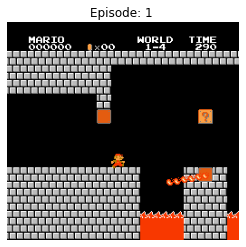

In [313]:
run(training_mode=False, pretrained=True, stage='SuperMarioBros-1-4-v0')